# Setup workspace

In [ ]:
pip install -r requirements.txt

In [3]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [4]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


# Import data

In [3]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# load the dataset
print("Loading Data...")
df = pd.read_csv('data/breast-cancer.data')

Loading Data...


In [4]:
df

,recurence,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


# Create a data asset

We create a data card to be used by our training pipeline

In [5]:
from azure.ai.ml.entities import Data

# Create a Data asset
data_asset = Data(
    path="data/breast-cancer.data",
    type="uri_file",
    name="cancer-data",
    description="Cancer data CSV file"
)

# Upload the data asset
ml_client.data.create_or_update(data_asset)

Data({'path': 'azureml://subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/breast_cancer/workspaces/mlw-breast_cancer/datastores/workspaceblobstore/paths/LocalUpload/3e28c2b024c43e7f9d7b04e56af90b9e/breast-cancer.data', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'cancer-data', 'description': 'Cancer data CSV file', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/data/cancer-data/versions/6', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-cancer-all/code/Users/noam.chretiennot/cloud-DP100-project', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f7029ed1300>, 'serialize': <msrest.seri

# Prepare data

In [6]:
# remove rows with missing values
df = df[df["node-caps"] != "?"]
df = df[df["breast-quad"] != "?"]

# split the data into X and y
X = df.drop("recurence", axis=1)
y = df["recurence"]

# convert the y to numeric
y= y.apply(lambda x: 1 if x == "recurrence-events" else 0)

# convert the age to numeric
X["age"] = X["age"].apply(lambda x: (int(x.split("-")[0])+int(x.split("-")[1]))/2)
# convert the menopause starting age to numeric
X["menopause"] = X["menopause"].apply(lambda x: 1 if x == "lt40" else (2 if x == "ge40" else 3))
# convert the tumor size to numeric
X["tumor-size"] = X["tumor-size"].apply(lambda x: (int(x.split("-")[0])+int(x.split("-")[1]))/2)
# convert the inv-nodes to numeric
X["inv-nodes"] = X["inv-nodes"].apply(lambda x: (int(x.split("-")[0])+int(x.split("-")[1]))/2)
# convert the node-caps to numeric
X["node-caps"] = X["node-caps"].apply(lambda x: 1 if x == "yes" else 0)
# convert the impacted breast to numeric
X["breast"] = X["breast"].apply(lambda x: 1 if x == "left" else 0)
# convert the breast-quad to one-hot encoding
X = pd.get_dummies(X, columns=["breast-quad"])
X["irradiat"] = X["irradiat"].apply(lambda x: 1 if x == "yes" else 0)

In [7]:
X

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,irradiat,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,34.5,3,32.0,1.0,0,3,1,0,False,True,False,False,False
1,44.5,3,22.0,1.0,0,2,0,0,False,False,False,False,True
2,44.5,3,22.0,1.0,0,2,1,0,False,True,False,False,False
3,64.5,2,17.0,1.0,0,2,0,0,False,False,True,False,False
4,44.5,3,2.0,1.0,0,2,0,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,34.5,3,32.0,1.0,0,2,1,0,False,False,True,False,False
282,34.5,3,22.0,1.0,0,3,1,1,False,False,True,False,False
283,64.5,2,22.0,1.0,0,1,0,0,False,False,True,False,False
284,44.5,2,32.0,4.0,0,3,1,0,False,True,False,False,False


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'menopause'}>,
        <Axes: title={'center': 'tumor-size'}>],
       [<Axes: title={'center': 'inv-nodes'}>,
        <Axes: title={'center': 'node-caps'}>,
        <Axes: title={'center': 'deg-malig'}>],
       [<Axes: title={'center': 'breast'}>,
        <Axes: title={'center': 'irradiat'}>, <Axes: >]], dtype=object)

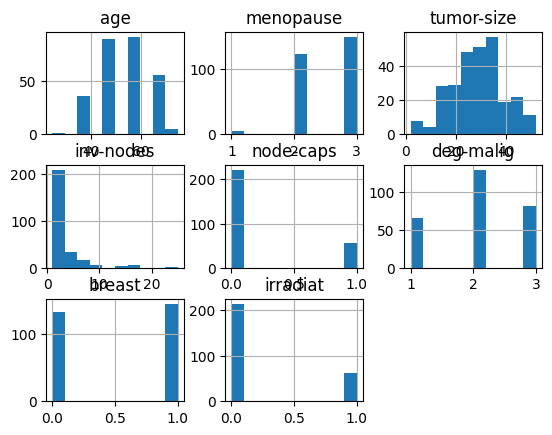

In [8]:
X.hist()

<Axes: >

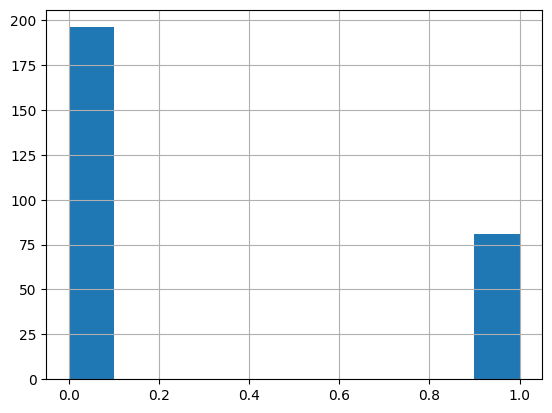

In [9]:
y.hist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# over sample so the minority class represents 50% of the data
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<Axes: >

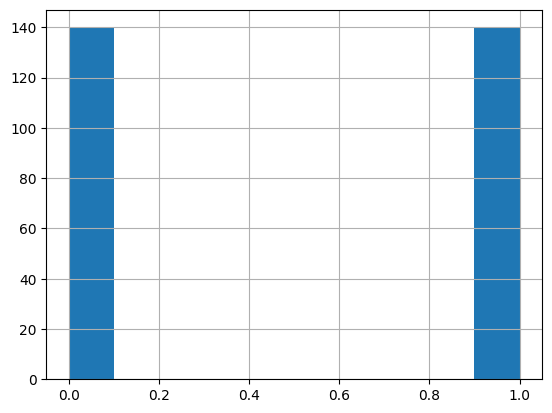

In [12]:
y_train_resampled.hist()

# Test models

We explore different models with ml flow

In [13]:
import mlflow

experiment_name = "mlflow-breast-cancer"
mlflow.set_experiment(experiment_name)
mlflow.sklearn.autolog(disable=True)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/azureml/mlflow/_protos/aml_service_pb2.py:10: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/01/27 04:32:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run stoic_ghost_jx8tx2ck at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/f2a6520c-50a6-4bb4-8ee9-f26bf8bb268b.
2025/01/27 04:32:03 INFO mlflow.tracking._tracking_service.client:

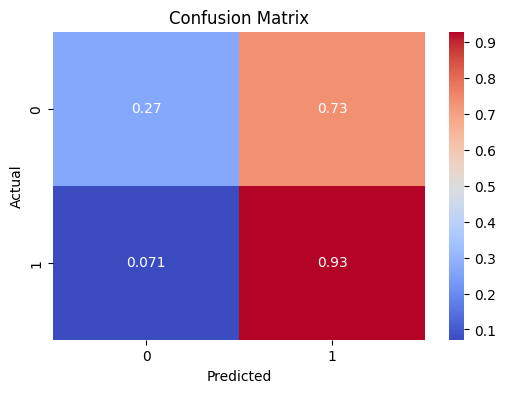

In [15]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

with mlflow.start_run():
    # train the model
    model = LogisticRegression(class_weight={0:1, 1:6}).fit(X_train_resampled, y_train_resampled)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "logistic regression base")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/27 04:32:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run maroon_floor_m4ggp8tr at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/5bc47d46-d7d8-4e59-864e-1949bfcd9bca.
2025/01/27 04:32:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


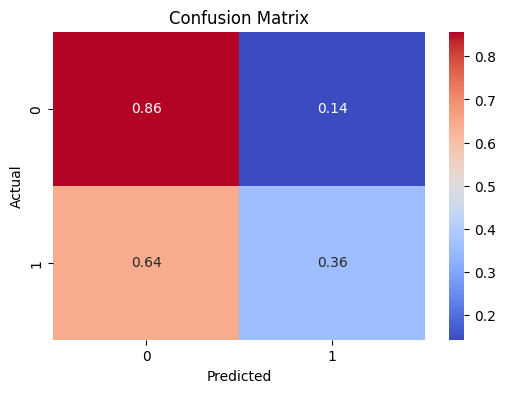

In [16]:
from xgboost import XGBClassifier

with mlflow.start_run():
    # train the model
    model = XGBClassifier().fit(X_train_resampled, y_train_resampled)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "xgboost")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/27 04:35:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run gray_collar_r0fwm8dd at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/0939e46f-1851-4b41-a2f1-04246bebd04e.
2025/01/27 04:35:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


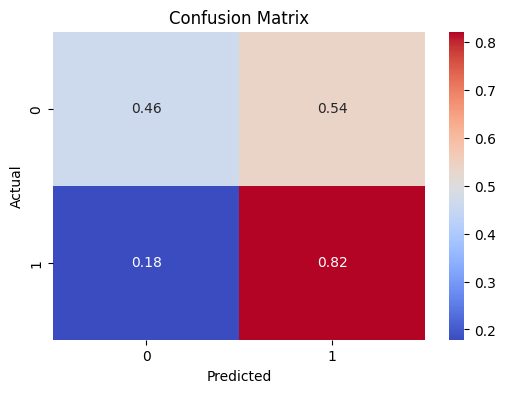

In [31]:
from sklearn.svm import SVC

with mlflow.start_run():
    # train the model
    model = SVC(class_weight={0:1, 1:3}).fit(X_train, y_train)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "svm")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/27 04:36:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run zen_puppy_z1y3bhjt at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/f0b6074e-7696-4373-9b2d-8313cc9965df.
2025/01/27 04:36:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


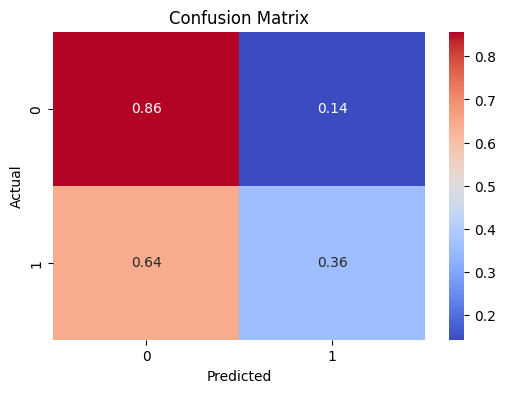

In [32]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    # train the model
    model = RandomForestClassifier().fit(X_train_resampled, y_train_resampled)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "random forest")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

In [33]:
# Search for all runs
runs = mlflow.search_runs()

# order by ROC_AUC
runs = runs.sort_values(by=["metrics.ROC_AUC"], ascending=False)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Accuracy,metrics.ROC_AUC,params.model,params.gamma,params.C,tags.mlflow.runName,tags.mlflow.rootRunId,tags.mlflow.user,tags.mlflow.job
9,c12e9daf-8ce8-4a30-8f9b-3d33553d32e7,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,RUNNING,,2025-01-26 22:11:32.578000+00:00,NaT,0.619048,0.678571,svm,None,None,tough_boat_ycm7c4jg,c12e9daf-8ce8-4a30-8f9b-3d33553d32e7,Noam CHRETIENNOT,None
19,b6ef6551-132f-4fc2-87c6-4842aa9682d2,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:33:50.940000+00:00,2025-01-27 04:33:52.522000+00:00,0.559524,0.660714,svm,None,None,heroic_bee_tbpx7sz6,b6ef6551-132f-4fc2-87c6-4842aa9682d2,Noam CHRETIENNOT,None
13,04a34516-c172-456c-a194-2602922e548f,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:32:21.225000+00:00,2025-01-27 04:32:23.323000+00:00,0.547619,0.660714,svm,None,None,sharp_tooth_pj861hrx,04a34516-c172-456c-a194-2602922e548f,Noam CHRETIENNOT,None
4,c1ae077b-4377-4af4-99b6-f19dc3a9c823,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:59.189000+00:00,2025-01-26 18:44:01.642000+00:00,0.630952,0.651786,svm_best,0.12495255175499978,0.12116472424736549,amiable_nose_n64ql38q,c1ae077b-4377-4af4-99b6-f19dc3a9c823,Noam CHRETIENNOT,None
16,117d3129-029e-4725-bcfa-e814ce0895fc,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:33:01.164000+00:00,2025-01-27 04:33:03.386000+00:00,0.690476,0.651786,svm,None,None,dreamy_key_xkkl3skn,117d3129-029e-4725-bcfa-e814ce0895fc,Noam CHRETIENNOT,None
25,ee8ee16b-19a1-4ec0-9cc1-bc266cdca7ee,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:35:23.964000+00:00,2025-01-27 04:35:25.925000+00:00,0.690476,0.651786,svm,None,None,modest_thread_1j7r4knd,ee8ee16b-19a1-4ec0-9cc1-bc266cdca7ee,Noam CHRETIENNOT,None
24,a8d29e9b-983a-4c72-82b8-ad88ed2b3188,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:35:15.213000+00:00,2025-01-27 04:35:17.055000+00:00,0.690476,0.642857,svm,None,None,maroon_owl_bzp08pvc,a8d29e9b-983a-4c72-82b8-ad88ed2b3188,Noam CHRETIENNOT,None
27,0939e46f-1851-4b41-a2f1-04246bebd04e,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:35:50.359000+00:00,2025-01-27 04:35:52.238000+00:00,0.583333,0.642857,svm,None,None,gray_collar_r0fwm8dd,0939e46f-1851-4b41-a2f1-04246bebd04e,Noam CHRETIENNOT,None
14,709e99a6-2b0f-4767-a6ca-ab6c096dc07b,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:32:37.384000+00:00,2025-01-27 04:32:39.571000+00:00,0.583333,0.642857,svm,None,None,good_king_frdw4znp,709e99a6-2b0f-4767-a6ca-ab6c096dc07b,Noam CHRETIENNOT,None
7,8f1fc6c5-1664-4cd7-8927-4811249aa3b6,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 22:06:44.148000+00:00,2025-01-26 22:06:46.455000+00:00,0.642857,0.642857,svm,None,None,mighty_plow_pxgbj9dn,8f1fc6c5-1664-4cd7-8927-4811249aa3b6,Noam CHRETIENNOT,SVM


# Tuning Hyper-parameters

In [58]:
import optuna
import math

# fine tune the SVM model to maximize the number of true positives
def objective(trial):
    C = trial.suggest_float("C", 0.1, 10)
    gamma = trial.suggest_float("gamma", 0.1, 10)
    model = SVC(class_weight={0:1, 1:3}, C=C, gamma=gamma).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-01-27 04:41:20,432] A new study created in memory with name: no-name-ecf5de02-c844-4085-857b-ef8f65365a0e
[I 2025-01-27 04:41:20,445] Trial 0 finished with value: 0.5178571428571429 and parameters: {'C': 3.388186156501135, 'gamma': 5.381443922842614}. Best is trial 0 with value: 0.5178571428571429.
[I 2025-01-27 04:41:20,456] Trial 1 finished with value: 0.5 and parameters: {'C': 9.98622808086555, 'gamma': 0.6478712381536158}. Best is trial 0 with value: 0.5178571428571429.
[I 2025-01-27 04:41:20,466] Trial 2 finished with value: 0.5178571428571429 and parameters: {'C': 4.627553859930016, 'gamma': 8.043722598643594}. Best is trial 0 with value: 0.5178571428571429.
[I 2025-01-27 04:41:20,476] Trial 3 finished with value: 0.5178571428571429 and parameters: {'C': 7.5773988856050005, 'gamma': 9.474065619547993}. Best is trial 0 with value: 0.5178571428571429.
[I 2025-01-27 04:41:20,486] Trial 4 finished with value: 0.5089285714285714 and parameters: {'C': 3.8455293794735086, 'gamma

In [59]:
study.best_params

{'C': 3.388186156501135, 'gamma': 5.381443922842614}

2025/01/27 04:41:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run eager_drop_8p6h17zx at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/464a3202-be1b-4082-8c76-297c88abe20e.
2025/01/27 04:41:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


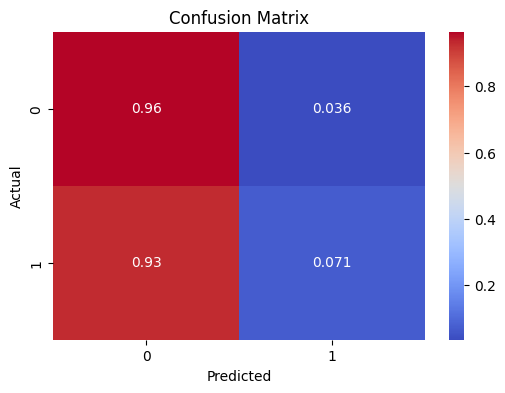

In [60]:
with mlflow.start_run():
    # train the SVM model with the best parameters (+ uses class_weight instead of resampling)
    model = SVC(class_weight={0:1, 1:3}, **study.best_params).fit(X_train, y_train)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "svm")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

it doesn't appear to be useful

In [61]:
# Search for all runs
runs = mlflow.search_runs()

# order by ROC_AUC
runs = runs.sort_values(by=["metrics.ROC_AUC"], ascending=False)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Accuracy,metrics.ROC_AUC,params.model,params.gamma,params.C,tags.mlflow.runName,tags.mlflow.rootRunId,tags.mlflow.user,tags.mlflow.job
9,c12e9daf-8ce8-4a30-8f9b-3d33553d32e7,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,RUNNING,,2025-01-26 22:11:32.578000+00:00,NaT,0.619048,0.678571,svm,None,None,tough_boat_ycm7c4jg,c12e9daf-8ce8-4a30-8f9b-3d33553d32e7,Noam CHRETIENNOT,None
13,04a34516-c172-456c-a194-2602922e548f,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:32:21.225000+00:00,2025-01-27 04:32:23.323000+00:00,0.547619,0.660714,svm,None,None,sharp_tooth_pj861hrx,04a34516-c172-456c-a194-2602922e548f,Noam CHRETIENNOT,None
19,b6ef6551-132f-4fc2-87c6-4842aa9682d2,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:33:50.940000+00:00,2025-01-27 04:33:52.522000+00:00,0.559524,0.660714,svm,None,None,heroic_bee_tbpx7sz6,b6ef6551-132f-4fc2-87c6-4842aa9682d2,Noam CHRETIENNOT,None
4,c1ae077b-4377-4af4-99b6-f19dc3a9c823,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:59.189000+00:00,2025-01-26 18:44:01.642000+00:00,0.630952,0.651786,svm_best,0.12495255175499978,0.12116472424736549,amiable_nose_n64ql38q,c1ae077b-4377-4af4-99b6-f19dc3a9c823,Noam CHRETIENNOT,None
16,117d3129-029e-4725-bcfa-e814ce0895fc,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:33:01.164000+00:00,2025-01-27 04:33:03.386000+00:00,0.690476,0.651786,svm,None,None,dreamy_key_xkkl3skn,117d3129-029e-4725-bcfa-e814ce0895fc,Noam CHRETIENNOT,None
25,ee8ee16b-19a1-4ec0-9cc1-bc266cdca7ee,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:35:23.964000+00:00,2025-01-27 04:35:25.925000+00:00,0.690476,0.651786,svm,None,None,modest_thread_1j7r4knd,ee8ee16b-19a1-4ec0-9cc1-bc266cdca7ee,Noam CHRETIENNOT,None
24,a8d29e9b-983a-4c72-82b8-ad88ed2b3188,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:35:15.213000+00:00,2025-01-27 04:35:17.055000+00:00,0.690476,0.642857,svm,None,None,maroon_owl_bzp08pvc,a8d29e9b-983a-4c72-82b8-ad88ed2b3188,Noam CHRETIENNOT,None
31,22f8425f-42a0-40a1-9ef9-e9cae864fc03,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:37:45.291000+00:00,2025-01-27 04:37:47.127000+00:00,0.619048,0.642857,svm,None,None,sleepy_salt_pbzmpf2q,22f8425f-42a0-40a1-9ef9-e9cae864fc03,Noam CHRETIENNOT,None
27,0939e46f-1851-4b41-a2f1-04246bebd04e,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:35:50.359000+00:00,2025-01-27 04:35:52.238000+00:00,0.583333,0.642857,svm,None,None,gray_collar_r0fwm8dd,0939e46f-1851-4b41-a2f1-04246bebd04e,Noam CHRETIENNOT,None
14,709e99a6-2b0f-4767-a6ca-ab6c096dc07b,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-27 04:32:37.384000+00:00,2025-01-27 04:32:39.571000+00:00,0.583333,0.642857,svm,None,None,good_king_frdw4znp,709e99a6-2b0f-4767-a6ca-ab6c096dc07b,Noam CHRETIENNOT,None


# Create a pipeline to train the model

In [65]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component

parent_dir = ""

clean_data = load_component(source=parent_dir + "envs/clean-data.yml")
train_logistic_regression = load_component(source=parent_dir + "envs/train-model.yml")

@pipeline()
def cancer_classification(pipeline_job_input):
    cleaned_data = clean_data(input_data=pipeline_job_input)
    train_model = train_logistic_regression(training_data=cleaned_data.outputs.output_data)

    # pipeline ports
    return {
        "pipeline_job_transformed_data": cleaned_data.outputs.output_data,
        "pipeline_job_trained_model": train_model.outputs.model,
    }

pipeline_job = cancer_classification(Input(type=AssetTypes.URI_FILE, path="azureml:cancer-data:1"))

In [66]:
# change the output mode
pipeline_job.outputs.pipeline_job_transformed_data.mode = "upload"
pipeline_job.outputs.pipeline_job_trained_model.mode = "upload"
# set pipeline level compute
pipeline_job.settings.default_compute = "aml-cluster"
# set pipeline level datastore
pipeline_job.settings.default_datastore = "workspaceblobstore"

# print the pipeline job again to review the changes
print(pipeline_job)

display_name: cancer_classification
type: pipeline
inputs:
  pipeline_job_input:
    type: uri_file
    path: azureml:cancer-data:1
outputs:
  pipeline_job_transformed_data:
    mode: upload
    type: uri_folder
  pipeline_job_trained_model:
    mode: upload
    type: mlflow_model
jobs:
  cleaned_data:
    type: command
    inputs:
      input_data:
        path: ${{parent.inputs.pipeline_job_input}}
    outputs:
      output_data: ${{parent.outputs.pipeline_job_transformed_data}}
    component:
      $schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
      name: clean_data
      version: '1'
      display_name: clean training data
      type: command
      inputs:
        input_data:
          type: uri_file
      outputs:
        output_data:
          type: uri_folder
      command: python clean-data.py  --input_data ${{inputs.input_data}} --output_data
        ${{outputs.output_data}}
      environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cp

In [67]:
# upload the pipeline job
pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="pipeline_cancer"
)

# execute the pipeline job
pipeline_job

pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored
pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.MLFlowModelJobOutput'> and will be ignored


Experiment,Name,Type,Status,Details Page
pipeline_cancer,tender_battery_8yckz0gry6,pipeline,NotStarted,Link to Azure Machine Learning studio


# Deploy the models to endpoint

## Create the endpoint

In [5]:
from azure.ai.ml.entities import ManagedOnlineEndpoint

online_endpoint_name = "endpoint-cancer"

endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Online endpoint for MLflow cancer model",
    auth_mode="key",
)

In [73]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/score', 'openapi_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/swagger.json', 'name': 'endpoint-cancer', 'description': 'Online endpoint for MLflow cancer model', 'tags': {}, 'properties': {'createdBy': 'Noam CHRETIENNOT', 'createdAt': '2025-01-27T05:15:48.905263+0000', 'lastModifiedAt': '2025-01-27T05:15:48.905263+0000', 'azureml.onlineendpointid': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/breast_cancer/providers/microsoft.machinelearningservices/workspaces/mlw-breast_cancer/onlineendpoints/endpoint-cancer', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/oeidp:4686e71d-6618-4df2-b0cb-7d9915eed2ad:184c1ab7-3c67-4d59-b4a7-fafd

## Choose the model

we load it from local files because of environnment bugs in Azure that were easier to modify by hand, rather than from the registry

In [6]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

model = Model(
    path="./model",
    type=AssetTypes.MLFLOW_MODEL,
    description="svm model for cancer recurrence prediction",
)

## Create a deployment to the endpoint

it will take 100% of the traffic to the endpoint

In [7]:
from azure.ai.ml.entities import ManagedOnlineDeployment

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_F2s_v2",
    instance_count=1,
)

In [76]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint endpoint-cancer exists
Uploading model (0.02 MBs): 100%|██████████| 24206/24206 [00:00<00:00, 782478.15it/s]




.......................................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'endpoint-cancer', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/odidp:4686e71d-6618-4df2-b0cb-7d9915eed2ad:47d4813d-fc46-488d-90c4-1ef330b65bb3?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/onlineEndpoints/endpoint-cancer/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-cancer-all/code/Users/noam.chretiennot/cloud-DP100-project', 'creation_context': <azure.ai.ml._restclient.v2023_04_01_prev

In [8]:
# blue deployment takes 100% traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/score', 'openapi_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/swagger.json', 'name': 'endpoint-cancer', 'description': 'Online endpoint for MLflow cancer model', 'tags': {}, 'properties': {'createdBy': 'Noam CHRETIENNOT', 'createdAt': '2025-01-27T05:15:48.905263+0000', 'lastModifiedAt': '2025-01-27T06:14:54.506573+0000', 'azureml.onlineendpointid': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/breast_cancer/providers/microsoft.machinelearningservices/workspaces/mlw-breast_cancer/onlineendpoints/endpoint-cancer', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/oeidp:4686e71d-6618-4df2-b0cb-7d9915eed2ad:158e547a-9d6c-4417-872f-c28c

# Test the endpoint

In [9]:
# Test the blue deployment with some sample data
response = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="blue",
    request_file="sample-data.json"
)

In [10]:
if response[1] =='1':
    print("Recurrence")
else:
    print("No Recurrence")

Recurrence


In [11]:
ml_client.online_endpoints.get(name=online_endpoint_name).scoring_uri

'https://endpoint-cancer.francecentral.inference.ml.azure.com/score'

In [12]:
DATA_PLANE_TOKEN = ml_client.online_endpoints.get_keys(name=online_endpoint_name).primary_key
with open(".env", "w") as f:
    f.write(f"API_KEY={DATA_PLANE_TOKEN}\n")

In [13]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'blue': 100}
https://endpoint-cancer.francecentral.inference.ml.azure.com/score


# Delete the endpoint

In [ ]:
# delete the online endpoint
# ml_client.online_endpoints.begin_delete(name=online_endpoint_name)